# MLP idea

In [1]:
import os
import torch
import math
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

PyTorch has version 2.3.1+cu121 with cuda 12.1


In [149]:
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Input

In [150]:
# Define material properties
Vs_values = np.array([140,250,1000,1500,2000,100,500,800,950,2500], dtype=float)
f_values = np.array([1, 1.5, 1.75, 2.25, 3], dtype=float)
t_values = np.linspace(0.5, 2.5, 10)

# Create a list of all possible combinations of Vs, f, and t
Vs_val, f_val, t_val = np.meshgrid(Vs_values, f_values, t_values, indexing='ij')
Vs_val = Vs_val.flatten()
f_val = f_val.flatten()
t_val = t_val.flatten()

# Create array with the combinations
data = np.array([Vs_val, f_val, t_val]).T

# Read all csv files from folder
folder_path = r"FLAC\FLAC2D - Case 1a\data"
files = os.listdir(folder_path)
files = [f for f in files if f.endswith('.csv')]

In [151]:
# Create DataSet class
class MyDataset(Dataset):
    def __init__(self, data, folder_path):
        self.data = data
        self.folder_path = folder_path

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Read the file
        file = files[idx]
        df = pd.read_csv(os.path.join(self.folder_path, file))
        # Get the data
        target = df.values[:, 1:]
        # Get the target
        input_2 = self.data[idx]

        # Get the additional input
        freq1 = input_2[1]
        t01 = input_2[2]
        t = df.values[:, 0]
        wave = -2*freq1**2*np.pi**2*np.exp(-freq1**2*np.pi**2*(t01 - t)**2)*(t01 - t)*(2*freq1**2*np.pi**2*t01**2 - 4*freq1**2*np.pi**2*t01*t + 2*freq1**2*np.pi**2*t**2 - 3)
        input_1 = wave
    
        # Get final input
        input_2 = input_2[0] * np.ones((30,))

        # Convert to tensor
        input_1 = torch.tensor(input_1, dtype=torch.float32)
        input_2 = torch.tensor(input_2, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)
        
        return input_1, input_2, target

In [208]:
import torch
from torch.utils.data import DataLoader, random_split

# Assuming MyDataset is already defined and data is loaded
dataset = MyDataset(data, folder_path)

# Define the sizes for training, validation, and testing sets
train_size = int(0.9 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
print(train_size, val_size, test_size)

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# Check the first batch of the training set
for i, (input_1, input_2, target) in enumerate(train_loader):
    print("Training set:", input_1.shape, input_2.shape, target.shape)
    break

# Check the first batch of the validation set
for i, (input_1, input_2, target) in enumerate(val_loader):
    print("Validation set:", input_1.shape, input_2.shape, target.shape)
    break

# Check the first batch of the testing set
for i, (input_1, input_2, target) in enumerate(test_loader):
    print("Testing set:", input_1.shape, input_2.shape, target.shape)
    break

450 25 25
Training set: torch.Size([10, 1500]) torch.Size([10, 30]) torch.Size([10, 1500, 2])
Validation set: torch.Size([10, 1500]) torch.Size([10, 30]) torch.Size([10, 1500, 2])
Testing set: torch.Size([10, 1500]) torch.Size([10, 30]) torch.Size([10, 1500, 2])


In [220]:
# Create Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

In [221]:
input_2.shape

torch.Size([10, 30])

In [223]:
class Model(nn.Module):
    def __init__(self, input_Vs, input_acc, output_dim, output_channels=2, batch_norm=False):
        super(Model, self).__init__()
        self.mlp1 = MLP(input_Vs, 100, 3, 30, batch_norm=batch_norm)
        self.mlp2 = MLP(input_acc, 100, 3, 30, batch_norm=batch_norm)
        self.mlp3 = MLP(60, 100, 4, output_dim*output_channels, batch_norm=batch_norm)
        
        self.output_dim = output_dim
        self.output_channels = output_channels

    def forward(self, acc, Vs):
        x1 = self.mlp1(Vs)
        x2 = self.mlp2(acc)
        x = torch.cat((x1, x2), dim=1)
        x = self.mlp3(x)
        x = x.view(-1, self.output_dim, self.output_channels)
        return x

In [224]:
# Check model

for i, (input_1, input_2, target) in enumerate(train_loader):
    break

print(input_1.shape, input_2.shape, target.shape)

model = Model(input_Vs=30, input_acc=1500, output_dim=1500)
pred = model(Vs=input_2, acc=input_1)
assert pred.shape == target.shape, f"Expected shape {target.shape} but got {pred.shape}"

# Define the loss function
loss_fn = nn.MSELoss()
loss = loss_fn(pred, target)
print(loss)

torch.Size([10, 1500]) torch.Size([10, 30]) torch.Size([10, 1500, 2])
tensor(5.0603, grad_fn=<MseLossBackward0>)


In [225]:
from tqdm import trange
import torch

def train(model, loss_function, optimizer, scheduler, train_dataloader, val_dataloader, epochs=100, device="cpu"):
    model.to(device)
    train_losses = []
    val_losses = []
    scaler = torch.cuda.amp.GradScaler()  # For mixed precision training

    for epoch in trange(epochs, desc="Training", unit="Epoch"):
        model.train()
        running_train_loss = 0.0
        for X1, X2, y in train_dataloader:
            X1, X2, y = X1.to(device, non_blocking=True), X2.to(device, non_blocking=True), y.to(device, non_blocking=True)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():  # Mixed precision context
                y_pred = model(X1, X2)
                single_loss = loss_function(y_pred, y)
            scaler.scale(single_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_train_loss += single_loss.item()
        
        scheduler.step()
        avg_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        for X1, X2, y in val_dataloader:
            X1, X2, y = X1.to(device, non_blocking=True), X2.to(device, non_blocking=True), y.to(device, non_blocking=True)
            with torch.no_grad():
                with torch.cuda.amp.autocast():  # Mixed precision context
                    y_pred = model(X1, X2)
                single_loss = loss_function(y_pred, y)
                running_val_loss += single_loss.item()
        
        avg_val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:3} Train Loss: {avg_train_loss:10.8f} Val Loss: {avg_val_loss:10.8f}')

    return train_losses, val_losses, model

In [226]:
# Define test function
def test(model, dataloader, device="cpu", loss_function=nn.MSELoss()):
    model.to(device)
    model.eval()
    predictions = []
    total_loss = 0
    with torch.no_grad():
        for X1, X2, y in dataloader:
            X1, X2, y = X1.to(device), X2.to(device), y.to(device)
            y_pred = model(X1, X2)
            predictions.append(y_pred)
            # Loss
            loss = loss_function(y_pred, y)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return predictions, avg_loss

In [227]:
model = Model(input_Vs=30, input_acc=1500, output_dim=1500, batch_norm=True)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)



In [228]:
# Check size of input
for i, (X1, X2, y) in enumerate(train_loader):
    print(f"X1 shape: {X1.shape}, X2 shape: {X2.shape}, y shape: {y.shape}")
    pred = model(X1, X2)
    print(f"Prediction shape: {pred.shape}, y shape: {y.shape}")
    loss = loss_function(pred, y)
    print(f"Loss: {loss}")
    break

X1 shape: torch.Size([10, 1500]), X2 shape: torch.Size([10, 30]), y shape: torch.Size([10, 1500, 2])
Prediction shape: torch.Size([10, 1500, 2]), y shape: torch.Size([10, 1500, 2])
Loss: 5.16208028793335


In [229]:
# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [230]:
# Train the model
train_losses, val_losses, model = train(model, loss_function, optimizer, scheduler, train_loader, val_loader, epochs=500, device=device)

Training:   0%|          | 1/500 [00:11<1:39:43, 11.99s/Epoch]

Epoch:   0 Train Loss: 5.02760925 Val Loss: 4.49087032


Training:   2%|▏         | 11/500 [00:39<27:41,  3.40s/Epoch] 

Epoch:  10 Train Loss: 4.22755181 Val Loss: 3.91842063


Training:   4%|▍         | 21/500 [01:12<25:29,  3.19s/Epoch]

Epoch:  20 Train Loss: 4.09258074 Val Loss: 3.74673891


Training:   6%|▌         | 31/500 [01:43<24:13,  3.10s/Epoch]

Epoch:  30 Train Loss: 3.99597676 Val Loss: 3.79613090


Training:   8%|▊         | 41/500 [02:13<22:00,  2.88s/Epoch]

Epoch:  40 Train Loss: 3.88268665 Val Loss: 3.67046301


Training:  10%|█         | 51/500 [02:39<23:14,  3.10s/Epoch]

Epoch:  50 Train Loss: 3.83496156 Val Loss: 3.59856661


Training:  12%|█▏        | 61/500 [03:11<23:14,  3.18s/Epoch]

Epoch:  60 Train Loss: 3.80457320 Val Loss: 3.55895185


Training:  14%|█▍        | 71/500 [03:43<23:03,  3.23s/Epoch]

Epoch:  70 Train Loss: 3.81127284 Val Loss: 3.61633897


Training:  16%|█▌        | 81/500 [04:18<24:04,  3.45s/Epoch]

Epoch:  80 Train Loss: 3.64355316 Val Loss: 3.51180577


Training:  18%|█▊        | 91/500 [04:36<11:20,  1.66s/Epoch]

Epoch:  90 Train Loss: 3.65614312 Val Loss: 3.43374594


Training:  20%|██        | 101/500 [04:53<12:02,  1.81s/Epoch]

Epoch: 100 Train Loss: 3.59159634 Val Loss: 3.28955420


Training:  22%|██▏       | 111/500 [05:12<12:15,  1.89s/Epoch]

Epoch: 110 Train Loss: 3.35233156 Val Loss: 3.30768681


Training:  24%|██▍       | 121/500 [05:29<12:39,  2.00s/Epoch]

Epoch: 120 Train Loss: 3.36352281 Val Loss: 3.28603649


Training:  26%|██▌       | 131/500 [06:00<19:20,  3.15s/Epoch]

Epoch: 130 Train Loss: 3.32030657 Val Loss: 3.28860903


Training:  28%|██▊       | 141/500 [06:24<11:37,  1.94s/Epoch]

Epoch: 140 Train Loss: 3.38362032 Val Loss: 3.19946559


Training:  30%|███       | 151/500 [06:39<08:36,  1.48s/Epoch]

Epoch: 150 Train Loss: 3.38511530 Val Loss: 3.26684848


Training:  32%|███▏      | 161/500 [06:54<08:18,  1.47s/Epoch]

Epoch: 160 Train Loss: 3.32053062 Val Loss: 3.25338229


Training:  34%|███▍      | 171/500 [07:13<13:03,  2.38s/Epoch]

Epoch: 170 Train Loss: 3.35243585 Val Loss: 3.20002333


Training:  36%|███▌      | 181/500 [07:45<16:46,  3.16s/Epoch]

Epoch: 180 Train Loss: 3.33039150 Val Loss: 3.23764292


Training:  38%|███▊      | 191/500 [08:16<16:00,  3.11s/Epoch]

Epoch: 190 Train Loss: 3.42355221 Val Loss: 3.20886207


Training:  40%|████      | 201/500 [08:48<16:17,  3.27s/Epoch]

Epoch: 200 Train Loss: 3.30763520 Val Loss: 3.09775798


Training:  42%|████▏     | 211/500 [09:08<09:17,  1.93s/Epoch]

Epoch: 210 Train Loss: 3.35842501 Val Loss: 3.14957579


Training:  44%|████▍     | 221/500 [09:26<07:40,  1.65s/Epoch]

Epoch: 220 Train Loss: 3.33457337 Val Loss: 3.25502610


Training:  46%|████▌     | 231/500 [09:41<06:34,  1.47s/Epoch]

Epoch: 230 Train Loss: 3.30261296 Val Loss: 3.15602382


Training:  48%|████▊     | 241/500 [09:57<07:26,  1.72s/Epoch]

Epoch: 240 Train Loss: 3.26779457 Val Loss: 3.26053715


Training:  50%|█████     | 251/500 [10:12<06:11,  1.49s/Epoch]

Epoch: 250 Train Loss: 3.27494291 Val Loss: 3.23249276


Training:  52%|█████▏    | 261/500 [10:28<06:16,  1.57s/Epoch]

Epoch: 260 Train Loss: 3.22962763 Val Loss: 3.18495107


Training:  54%|█████▍    | 271/500 [10:44<06:15,  1.64s/Epoch]

Epoch: 270 Train Loss: 3.32424227 Val Loss: 3.22640395


Training:  56%|█████▌    | 281/500 [10:59<05:42,  1.56s/Epoch]

Epoch: 280 Train Loss: 3.24259299 Val Loss: 3.23226062


Training:  58%|█████▊    | 291/500 [11:15<05:23,  1.55s/Epoch]

Epoch: 290 Train Loss: 3.27059081 Val Loss: 3.23727282


Training:  60%|██████    | 301/500 [11:43<10:10,  3.07s/Epoch]

Epoch: 300 Train Loss: 3.26806777 Val Loss: 3.19099021


Training:  62%|██████▏   | 311/500 [12:17<10:25,  3.31s/Epoch]

Epoch: 310 Train Loss: 3.22751622 Val Loss: 3.18608705


Training:  64%|██████▍   | 321/500 [12:50<09:38,  3.23s/Epoch]

Epoch: 320 Train Loss: 3.40718826 Val Loss: 3.07664847


Training:  66%|██████▌   | 331/500 [13:24<09:15,  3.29s/Epoch]

Epoch: 330 Train Loss: 3.32802458 Val Loss: 3.19922042


Training:  68%|██████▊   | 341/500 [13:56<08:30,  3.21s/Epoch]

Epoch: 340 Train Loss: 3.24564581 Val Loss: 3.39359784


Training:  70%|███████   | 351/500 [14:29<08:17,  3.34s/Epoch]

Epoch: 350 Train Loss: 3.24608434 Val Loss: 3.24348863


Training:  72%|███████▏  | 361/500 [15:03<07:51,  3.39s/Epoch]

Epoch: 360 Train Loss: 3.26304841 Val Loss: 3.19279401


Training:  74%|███████▍  | 371/500 [15:19<03:25,  1.60s/Epoch]

Epoch: 370 Train Loss: 3.28795550 Val Loss: 3.17656883


Training:  76%|███████▌  | 381/500 [15:35<03:02,  1.53s/Epoch]

Epoch: 380 Train Loss: 3.34439432 Val Loss: 3.21658731


Training:  78%|███████▊  | 391/500 [16:08<05:57,  3.28s/Epoch]

Epoch: 390 Train Loss: 3.29686442 Val Loss: 3.17071144


Training:  80%|████████  | 401/500 [16:40<05:17,  3.21s/Epoch]

Epoch: 400 Train Loss: 3.18157434 Val Loss: 3.13337644


Training:  82%|████████▏ | 411/500 [17:09<03:32,  2.39s/Epoch]

Epoch: 410 Train Loss: 3.33395101 Val Loss: 3.13268789


Training:  84%|████████▍ | 421/500 [17:26<02:10,  1.65s/Epoch]

Epoch: 420 Train Loss: 3.26333885 Val Loss: 3.16488441


Training:  86%|████████▌ | 431/500 [17:44<02:02,  1.78s/Epoch]

Epoch: 430 Train Loss: 3.24239780 Val Loss: 3.21846859


Training:  88%|████████▊ | 441/500 [18:02<01:47,  1.82s/Epoch]

Epoch: 440 Train Loss: 3.14947537 Val Loss: 3.16052111


Training:  90%|█████████ | 451/500 [18:31<02:46,  3.39s/Epoch]

Epoch: 450 Train Loss: 3.31359392 Val Loss: 3.15362215


Training:  92%|█████████▏| 461/500 [19:05<02:15,  3.48s/Epoch]

Epoch: 460 Train Loss: 3.23324400 Val Loss: 3.20495637


Training:  94%|█████████▍| 471/500 [19:38<01:35,  3.28s/Epoch]

Epoch: 470 Train Loss: 3.23212244 Val Loss: 3.23662408


Training:  96%|█████████▌| 481/500 [20:06<00:40,  2.15s/Epoch]

Epoch: 480 Train Loss: 3.28854526 Val Loss: 3.26086140


Training:  98%|█████████▊| 491/500 [20:22<00:14,  1.56s/Epoch]

Epoch: 490 Train Loss: 3.17937204 Val Loss: 3.21921293


Training: 100%|██████████| 500/500 [20:35<00:00,  2.47s/Epoch]


Text(0.5, 1.0, 'Training Loss')

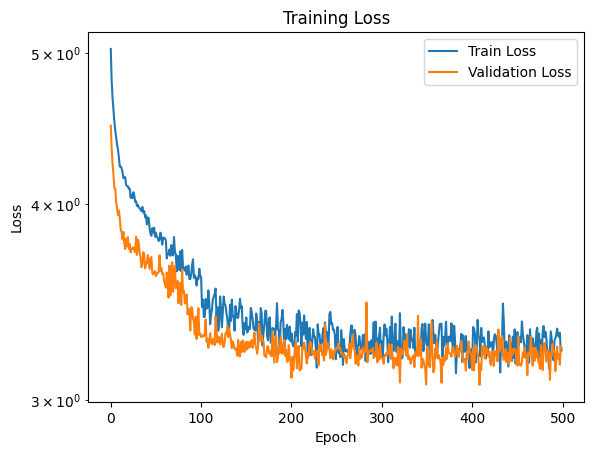

In [231]:
# Plot the losses
import seaborn as sns
sns.lineplot(x=range(len(train_losses)), y=train_losses, label="Train Loss")
sns.lineplot(x=range(len(val_losses)), y=val_losses, label="Validation Loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

Test Loss: 4.064711093902588
Test Loss per batch: 3.956911563873291
Test Loss per batch: 3.933271884918213
Test Loss per batch: 4.30394983291626


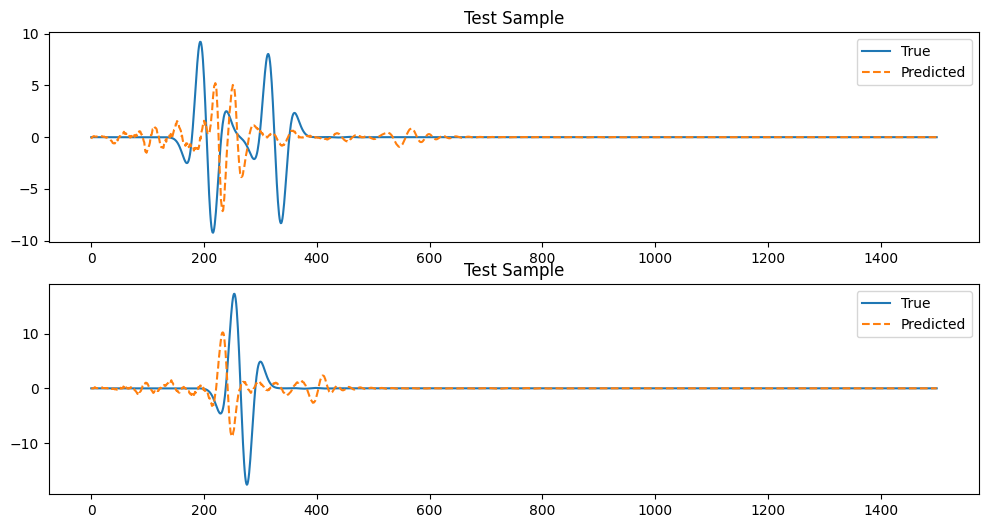

In [250]:
# Test the model
predictions, test_loss = test(model, test_loader, device=device)
print(f"Test Loss: {test_loss}")


for i, (X1, X2, y) in enumerate(test_loader):
    print("Test Loss per batch:", loss_function(predictions[i], y.to(device)).item())

    # Plot the first sample
    if i == 2:
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        plt.plot(y[0,:,0].cpu(), label="True")
        plt.plot(predictions[i][0,:,0].cpu().detach(), label="Predicted", linestyle="--")
        plt.legend()
        plt.title("Test Sample")
        
        plt.subplot(2, 1, 2)
        plt.plot(y[0,:,1].cpu(), label="True")
        plt.plot(predictions[i][0,:,1].cpu().detach(), label="Predicted", linestyle="--")
        plt.legend()
        plt.title("Test Sample")

    
